In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
cd '/content/drive/My Drive/lidar'

/content/drive/My Drive/lidar


In [ ]:
!pip install matplotlib
!pip install laspy
# !pip install geopandas
# !pip install pyntcloud
# !pip install gdal
# !pip install cuML

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for laspy: filename=laspy-2.4.1-py3-none-any.whl size=68045 sha256=27b669865d73ee431993976d69b5958a4aa8a0bcfd74ea1d5181c415ae397162
  Stored in directory: /root/.cache/pip/wheels/04/a4/0c/c8e8ba29abc06fafe864c7c4402748ceb617a7c057e8cc8579
Successfully built laspy


In [ ]:
import os
import matplotlib.pyplot as plt
import laspy
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# import pyntcloud

In [ ]:
data_folder = "data"

In [ ]:
# Open the .laz file
with laspy.open('data/gore_nz_smol.las') as fh:
    print('Points from Header:', fh.header.point_count)
    las = fh.read()
    print(las)
    print('Points from data:', len(las.points))
    ground_pts = las.classification == 2
    bins, counts = np.unique(las.return_number[ground_pts], return_counts=True)
    print('Ground Point Return Number distribution:')
    for r,c in zip(bins,counts):
        print('    {}:{}'.format(r,c))

Points from Header: 89691
<LasData(1.4, point fmt: <PointFormat(6, 0 bytes of extra dims)>, 89691 points, 2 vlrs)>
Points from data: 89691
Ground Point Return Number distribution:
    1:26568
    2:4309
    3:185
    4:1


In [ ]:
point_records = las.points
pointformat = las.point_format
# for spec in pointformat:
#     print(spec.name)

# list(pointformat.dimension_names)

In [ ]:
ground_points = las.points[(las.classification == 2) & (las.return_number == 1)]
building_points = las.points[(las.classification == 6) & (las.return_number == 1)]
unclassified_points = las.points[(las.classification == 1) & (las.return_number == 1)]


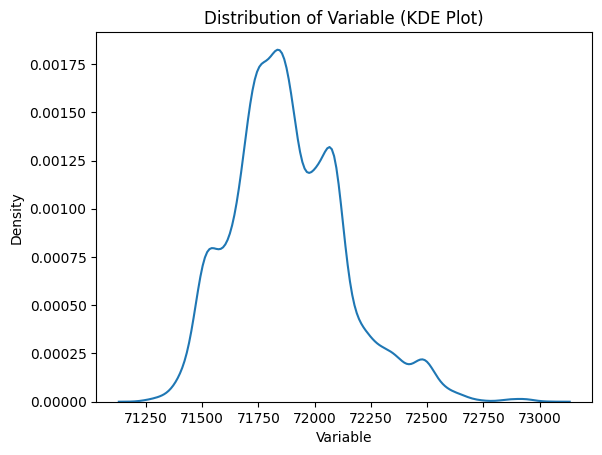

248.41469817783866
71883.00267238784


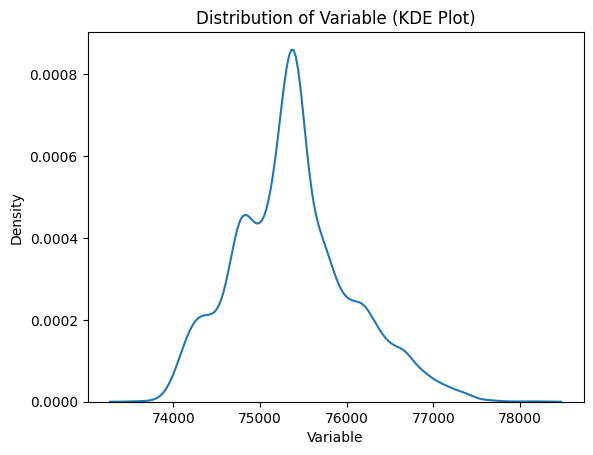

671.7239264470621
75380.98905649217


In [ ]:
import seaborn as sns

def show_stats(points):
  sns.kdeplot(points)
  plt.xlabel('Variable')
  plt.ylabel('Density')
  plt.title('Distribution of Variable (KDE Plot)')
  plt.show()
  print(np.std(points))
  print(np.mean(points))

show_stats(ground_points["Z"])

<ipython-input-10-6faa0b835b2a>:15: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x[cls_indices], y[cls_indices], c=cmap(i), label=cls, s=0.1)


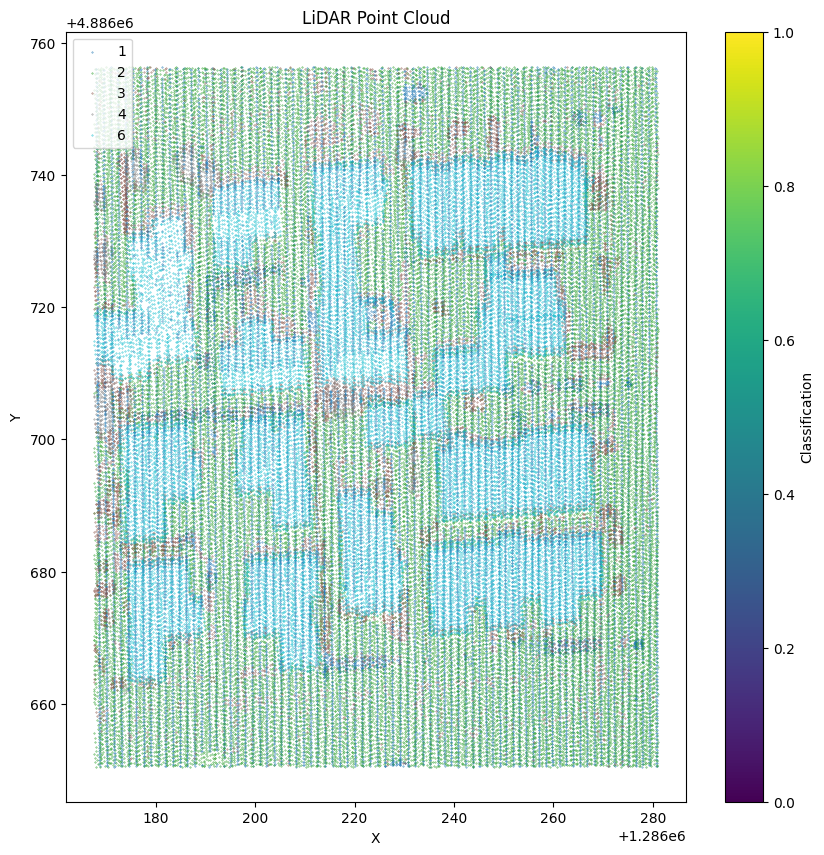

In [ ]:
x = las.x
y = las.y
classification = las.classification

# Get unique classification values
unique_classes = list(set(classification))

# Create a categorical color map for unique classes
cmap = plt.get_cmap("tab10", len(unique_classes))

# Create a scatter plot with color-coded points
plt.figure(figsize=(10, 10))
for i, cls in enumerate(unique_classes):
    cls_indices = classification == cls
    plt.scatter(x[cls_indices], y[cls_indices], c=cmap(i), label=cls, s=0.1)

plt.colorbar(label='Classification')
plt.title('LiDAR Point Cloud')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

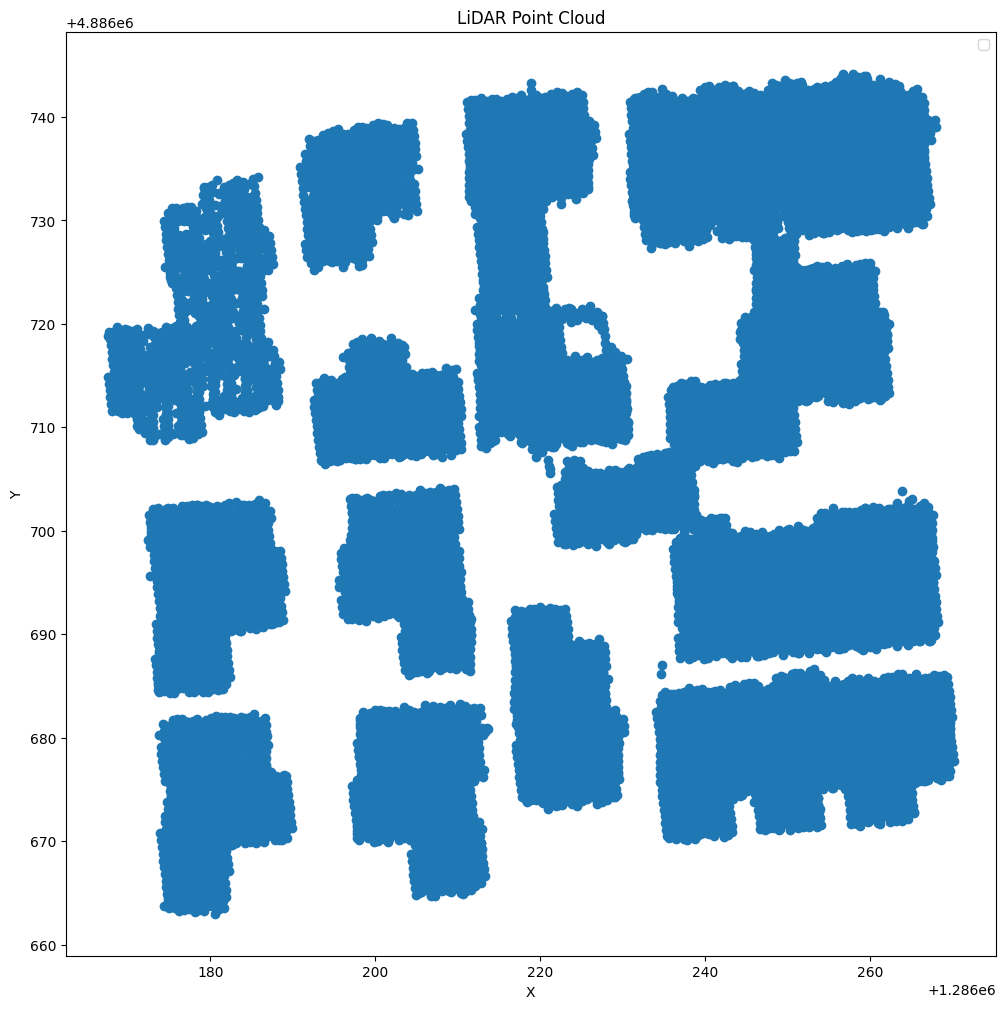

In [ ]:
building_points = las.points[las.classification == 6]

x = building_points.x
y = building_points.y

# Create a scatter plot with color-coded points
plt.figure(figsize=(12, 12))

plt.scatter(x, y)

plt.title('LiDAR Point Cloud')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

Number of buildings: 12


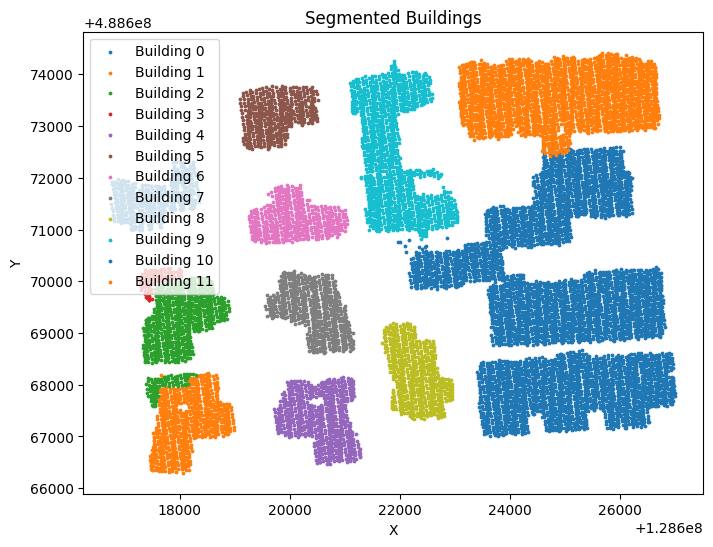

In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt

def segment_buildings(las):
  building_points = las.points[(las.classification == 6) & (las.return_number == 1)]
  x = building_points["X"]
  y = building_points["Y"]
  z = building_points["Z"]

  feature_matrix = np.column_stack((x, y, z))

  # Perform DBSCAN
  epsilon = 500
  min_samples = 100

  dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
  labels = dbscan.fit_predict(feature_matrix)

  unique_labels = np.unique(labels)
  unique_labels = unique_labels[unique_labels != -1]

  num_buildings = len(unique_labels)
  print("Number of buildings:", num_buildings)

  return unique_labels, labels, feature_matrix

unique_labels, labels, feature_matrix = segment_buildings(las)
# Color-coded 2D scatter plot
plt.figure(figsize=(8, 6))
for label in unique_labels:
    cluster_points = feature_matrix[labels == label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label="Building " + str(label), s=3)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Segmented Buildings")
plt.legend()
plt.show()



In [ ]:
building_points = feature_matrix[labels==0]
print(building_points.shape)
building_points

print(np.mean(building_points[:,2]))
print(np.mean(ground_points["Z"]))
print(np.var(ground_points["Z"]))

(429, 3)
76307.19813519814
71878.09419566687
62693.32544775066


In [ ]:
# Calculate the height of each building
building_heights = []
for label in unique_labels:
    building_points = feature_matrix[labels == label]
    building_height = np.mean(building_points[:, 2])  # Mean of Z coordinates
    building_heights.append(building_height)
    print("Building", label, "height:", building_height)

# for label, height in zip(unique_labels, building_heights):
#     print("Building", label, "height:", height)

Building 0 height: 76307.19813519814
Building 1 height: 74951.84120734908
Building 2 height: 75036.37308146399
Building 3 height: 74494.64
Building 4 height: 74930.27520435967
Building 5 height: 75394.08536585367
Building 6 height: 75546.99421965318
Building 7 height: 75172.8943338438
Building 8 height: 76209.32081377151
Building 9 height: 76085.72774098603
Building 10 height: 75341.76016736402
Building 11 height: 75375.91018711019


In [ ]:
with laspy.open('data/gore_nz.las') as fh:
    print('Points from Header:', fh.header.point_count)
    las_gore = fh.read()

Points from Header: 2519604


In [ ]:
ground_points_gore = las_gore.points[(las_gore.classification == 2) & (las_gore.return_number == 1)]
building_points_gore = las_gore.points[(las_gore.classification == 6) & (las_gore.return_number == 1)]
unclassified_points_gore = las_gore.points[(las_gore.classification == 1) & (las_gore.return_number == 1)]

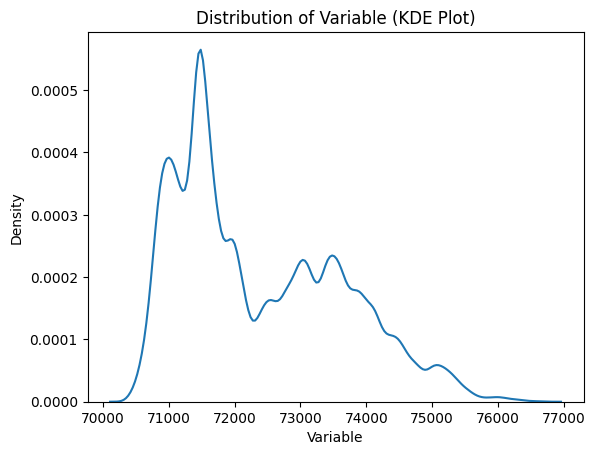

1255.150521028262
72386.75129961317


In [ ]:
show_stats(ground_points_gore["Z"])

Number of buildings: 543


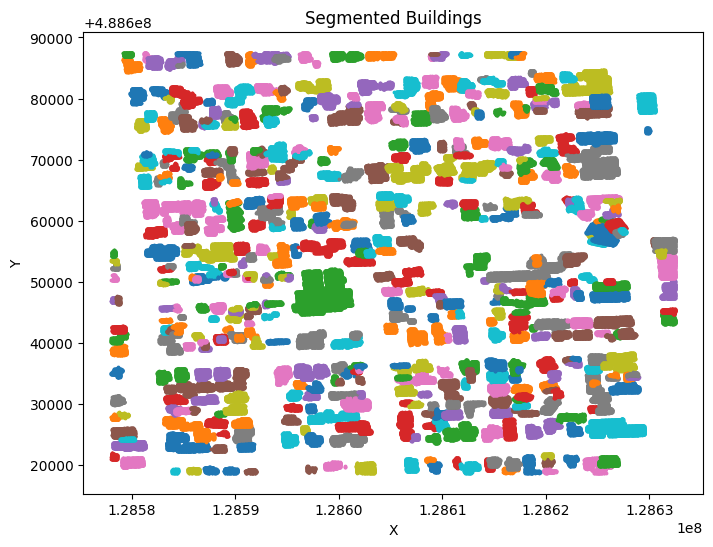

In [ ]:
unique_labels_gore, labels_gore, feature_matrix_gore = segment_buildings(las_gore)
# Color-coded 2D scatter plot
plt.figure(figsize=(8, 6))
for label in unique_labels_gore:
    cluster_points_gore = feature_matrix_gore[labels_gore == label]
    plt.scatter(cluster_points_gore[:, 0], cluster_points_gore[:, 1], label="Building " + str(label), s=3)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Segmented Buildings")
# plt.legend()
plt.show()